# 0. Initialize

## 0.1. Import Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import gzip
import random
import tqdm
import json
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt

## 0.2. DEFINE VARIABLES 

In [2]:
DATA_PATH = "./drive/My Drive/"

ROUND = 1 # This project will have 3 rounds of predictions: 1,2,3
STUDENT_ID = '28034'
PROJECT_CODE = 'CS412c244f51240ae' # Same code for the annotation eg. CS412xxxxx

## 0.3. Read Training & Evaluation Data

In [3]:
import pandas as pd 
from google.colab import drive
from os.path import join


# Read data
drive.mount('./drive', force_remount=True)
path_prefix = "./drive/My Drive/"

Mounted at ./drive


### 0.3.1. Get the labels for tweets

In [4]:
#trainingTweetDf = pd.read_csv('{}training-tweet.csv'.format(DATA_PATH))
trainingTweetDf = pd.read_csv(path_prefix+'annotated_tweets_CS412c244f51240ae.csv', dtype={'Unnamed: 0': str, 'isPolitical': str})
trainingTweetDf.rename(columns = {'Unnamed: 0' : 'tweet_id'}, inplace = True)
trainingTweetDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        250 non-null    object
 1   url             250 non-null    object
 2   sentiment       249 non-null    object
 3   isExperiential  249 non-null    object
 4   isPolitical     249 non-null    object
 5   isInsult        249 non-null    object
dtypes: object(6)
memory usage: 11.8+ KB


In [5]:
trainingTweetDf.isPolitical.value_counts()

Yes    181
No      68
Name: isPolitical, dtype: int64

### 0.3.2. Get the labels for users

In [6]:
#trainingUserDf = pd.read_csv('{}training-user.csv'.format(DATA_PATH))
trainingUserDf = pd.read_csv(path_prefix+'annotated_users_CS412c244f51240ae.csv')
trainingUserDf.rename(columns = {'Unnamed: 0' : 'user_name'}, inplace = True)
trainingUserDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         250 non-null    object
 1   url               250 non-null    object
 2   isOrganizational  249 non-null    object
 3   isBot             249 non-null    object
 4   isTroll           249 non-null    object
dtypes: object(5)
memory usage: 9.9+ KB


In [7]:
trainingUserDf.isBot.value_counts()

No          148
Yes          71
Not sure     30
Name: isBot, dtype: int64

### 0.3.3. Expand your dataset with metadata and tweets

In [8]:
# You can also expand training data by downloading your own labeled datasets following the link
# Download the documents under "Link to training data"

print('http://www.onurvarol.com/AnnotationTwitterTR/reports/report_{}.html'.format(PROJECT_CODE))

http://www.onurvarol.com/AnnotationTwitterTR/reports/report_CS412c244f51240ae.html


## 1. Landing Page

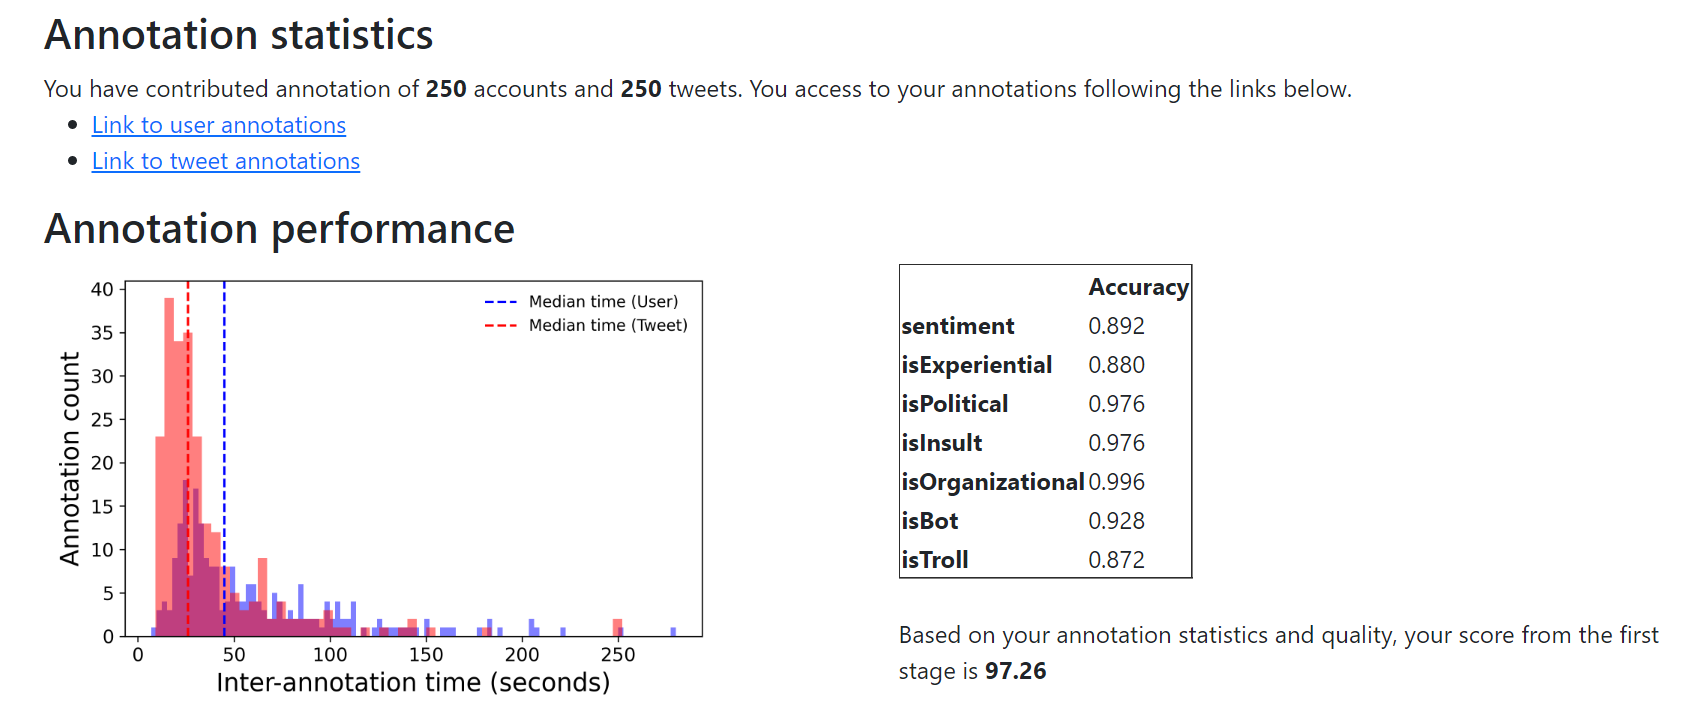

In [9]:
display.Image("https://i.imgur.com/IHvQHIf.png")

## 2. Link for Downloading Training Data

At the bottom of the page, you will see the **LINK FOR FILES**

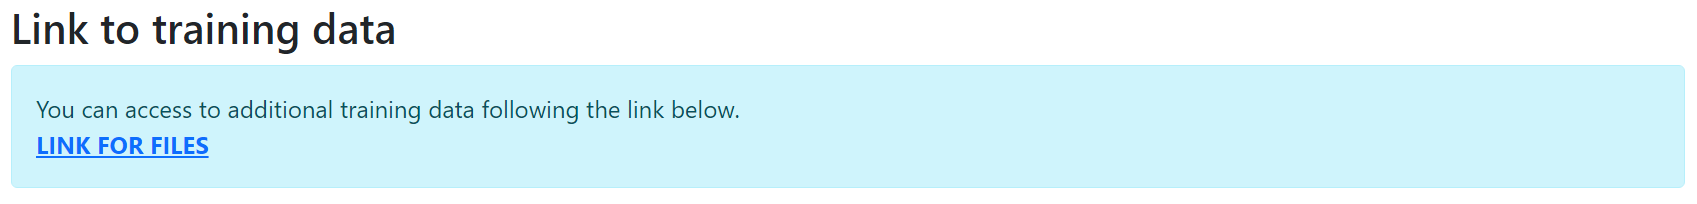

In [10]:
display.Image("https://i.imgur.com/t19vAjr.png")

## 3. Google Drive

You can download the following project files from Google Drive

- **user_profiles.jsons.gz**: Contains user metadata for bot detection phase of your project
- **user_tweets.jsons.gz**: Contains at most 200 tweets of the above mentioned users'
- **tweet_metadata.jsons.gz**: Contains tweets and their metadata for the political tweet detection of your project

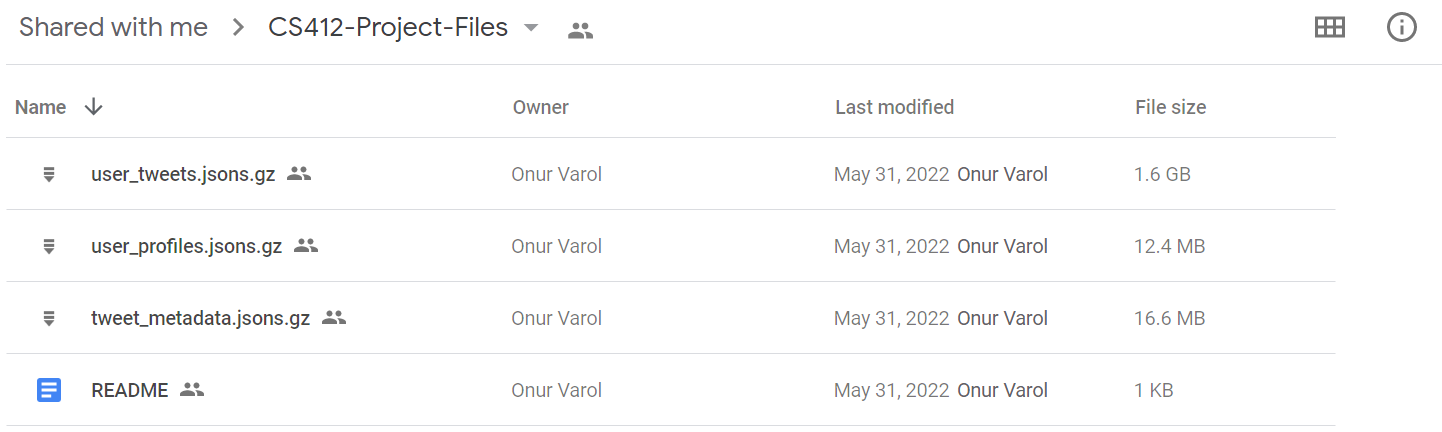

In [11]:
display.Image("https://i.imgur.com/7FjWPLi.png")

# 1. EXTRACT FEATURES
Under *1.1. Political Tweet Detection* and *1.2. Bot Detection*, we firstly collect raw data for processing. We then combine some of them (total_interactions = num_favorites + num_retweets) or use them to extract features (whether the tweet has one of the political entities @meralaksener, @kilicdarogluk etc.).

We expect you to collect more raw data from **tweet_metadata**, **user_profiles** and **user_tweets** files by creating a function as shown in below examples such as *check_if_retweet()* and using it while iterating over data as shown under *Merge Collected Features*.

We also expect you to create new variables as much as you can from the data in order to make your predictions more accurate. For example, you may want to check:

- The tweet sources that a user frequently uses
- Whether the user is a verified account or not

...

to assess whether **a user is a bot or not** and whether **a tweet is political or not**.

In [12]:
PATH_TO_DOWNLOADED = path_prefix #"./drive/My Drive/"

## 1.1. Political Tweet Detection
This part stands for the feature extraction of tweets. We start with collecting the raw data from *tweet_metadata*, then use some of them to extract features.

### 1.1.1. Get Raw Data

#### 1.1.1.1. Check if Retweet

In [13]:
def check_if_retweet(tweet_metadata_line):
    is_retweet = 0
    retweeted_username = None

    try:
        tweet_metadata_line['retweeted_status']
        retweeted_username = tweet_metadata_line['retweeted_status']['user']['screen_name'].lower()
        is_retweet = 1

    except KeyError:
        pass

    return is_retweet, retweeted_username

#### 1.1.1.2. Get Tweet Text

In [14]:
def get_tweet_text(tweet_metadata_line):
    text = tweet_metadata_line['text']
    
    return text

#### 1.1.1.3. Get Tweet ID

In [15]:
def get_tweet_id(tweet_metadata_line):
    id_str = tweet_metadata_line['id_str']
    
    return id_str

#### 1.1.1.4. Get Number of Mentions and Hashtags

In [16]:
def get_number_mentions_hashtags(tweet_metadata_line):
    num_mentions = len(tweet_metadata_line['entities']['user_mentions'])
    num_hashtags = len(tweet_metadata_line['entities']['hashtags'])

    return num_mentions, num_hashtags

#### 1.1.1.5. Get Number of Retweets and Favorites

In [17]:
def get_number_retweets_favorites(tweet_metadata_line):
    retweet_count = tweet_metadata_line['retweet_count']
    favorite_count = tweet_metadata_line['favorite_count']
    
    return retweet_count, favorite_count

#### 1.1.1.6. Get User Info

In [18]:
def get_user_info(tweet_metadata_line):
    id = tweet_metadata_line['user']['id_str']
    screen_name = tweet_metadata_line['user']['screen_name'].lower()
    description = tweet_metadata_line['user']['description']

    return id, screen_name, description

### 1.1.2. Derive Manually Crafted Features

#### 1.1.2.1. Check for political entity in text

In [19]:
def check_political_ent(text):
    
    # the list below can be modified and some new names may be added (or removed)
    list_of_entities = ['meral_aksener', 'kilicdarogluk', 'vekilince', 'RTErdogan', 'MevlutCavusoglu', 'umitozdag']
    
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

In [20]:
def get_verification(meta_line):
  return int(meta_line['user']['verified'])

#### 1.1.2.2. Number of total interactions

In [21]:
def total_interactions(retweet_count, favorite_count):
    total_num_interactions = retweet_count + favorite_count
    
    return total_num_interactions

### 1.1.2. Collect data using the functions above and transform into a Pandas DataFrame

In [22]:
dfPolitical = {'tweet_id':[],
              'is_retweet':[],
              'retweeted_username':[],
              'text':[],
              'num_mentions':[],
              'num_hashtags':[],
              'num_retweets':[],
              'num_favorites':[],
              'user_id':[],
              'user_screen_name':[],
              'user_description':[],
              'num_political_entities':[],
              'total_interactions':[],
              'is_verified' : []}


with gzip.open(f"{PATH_TO_DOWNLOADED}tweet_metadata.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)
        
        # raw data:
        id_str = get_tweet_id(line)
        is_retweet, retweeted_username = check_if_retweet(line)
        text = get_tweet_text(line)
        num_mentions, num_hashtags = get_number_mentions_hashtags(line)
        retweet_count, favorite_count = get_number_retweets_favorites(line)
        user_id_str, screen_name, user_description = get_user_info(line)

        # manually crafted data:
        num_political_entities = check_political_ent(text)
        total_num_interactions = total_interactions(retweet_count, favorite_count)
        verified = get_verification(line)

        dfPolitical['tweet_id'].append(id_str)
        dfPolitical['is_retweet'].append(is_retweet)
        dfPolitical['retweeted_username'].append(retweeted_username)
        dfPolitical['text'].append(text)
        dfPolitical['num_mentions'].append(num_mentions)
        dfPolitical['num_hashtags'].append(num_hashtags)
        dfPolitical['num_retweets'].append(retweet_count)
        dfPolitical['num_favorites'].append(favorite_count)
        dfPolitical['user_id'].append(user_id_str)
        dfPolitical['user_screen_name'].append(screen_name)
        dfPolitical['user_description'].append(user_description)
        dfPolitical['num_political_entities'].append(num_political_entities)
        dfPolitical['total_interactions'].append(total_num_interactions)
        dfPolitical['is_verified'].append(verified)

In [23]:
pd.DataFrame(dfPolitical['is_verified']).value_counts()

0    32763
1      239
dtype: int64

In [24]:
dfPolitical = pd.DataFrame(dfPolitical)
dfPolitical

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,total_interactions,is_verified
0,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,0,0
1,1445677417150889986,1,ekrem_imamoglu,RT @ekrem_imamoglu: Geldikleri gibi gittiler… ...,1,0,6706,0,1263130166961864705,hasanak11633015,64 Jahre alt,0,6706,0
2,1456638729620230149,1,yenisafak,RT @yenisafak: İYİ PARTİLİ TÜRKKAN ŞEHİT AĞABE...,1,0,1545,0,2958652582,buyukdogu58,Katılıyorum: RT+FAV,0,1545,0
3,1451295314074341381,1,ekrem_imamoglu,RT @ekrem_imamoglu: Bu gece ben: ❤️💛\nTebrikle...,1,0,7470,0,1447285927471112194,gskaya444,,0,7470,0
4,1440610747134844929,1,umitozdag,RT @umitozdag: Sayın Bakan demek yüzmeyi öğren...,1,0,745,0,379944275,cerenncan,,1,745,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32997,1439639972177489926,1,deryayanikashb,RT @deryayanikashb: AK Parti Çanakkale İl Başk...,1,0,48,0,165689533,sezayicimen,İst.Aydın Üniversitesi Mahalli İdareler ve Yer...,0,48,0
32998,1467519965473423362,1,kilicdarogluk,RT @kilicdarogluk: Türkiye Barolar Birliği 36....,1,0,4438,0,408719429,sdiplen1,Hepimiz birileri için kurallarımızı çiğnedik,1,4438,0
32999,1423666826282668035,1,rterdogan,RT @RTErdogan: Geleceğe Nefes kampanyasıyla he...,1,0,14311,0,1004379711890485248,soguzsoylu,AK Parti Yumurtalık İlçe Başkanı,1,14311,0
33000,1417025303894007810,1,thetubaca,RT @thetubaca: Hasta tutuklu Ekim Polat açlık ...,3,0,16,0,1049663929348222985,mhmt_ckmk04,667 ile yılları çalınan gurebadan bir garip...,0,16,0


## 1.2. From Users

### 1.2.1. Get user metadata from user_profiles.jsons.gz

#### 1.2.1.1. Get user info metadata

In [25]:
def get_verification_user(meta_line):
  return int(meta_line['verified'])

In [26]:
def get_user_info_metadata(user_metadata_line):
    
    user_id = user_metadata_line['id_str']
    user_name = user_metadata_line['name']
    user_screen_name = user_metadata_line['screen_name'].lower()
    user_location = user_metadata_line['location']
    user_description = user_metadata_line['description']
    user_followers_count = user_metadata_line['followers_count']
    user_friends_count = user_metadata_line['friends_count']
    verified = get_verification_user(user_metadata_line)
    
    
    dictionary = {'user_id':user_id, 'user_name': user_name, 'user_screen_name':user_screen_name, 'user_location':user_location,
     'user_description':user_description, 'user_followers_count':user_followers_count, 'user_friends_count':user_friends_count,'is_verified':verified}

    return dictionary

#### 1.2.1.2. Get followers/(followers+friends) ratio

In [27]:
def get_followers_all_ratio(user_followers_count, user_friends_count):
    
    if user_friends_count + user_followers_count == 0:
        followers_all_ratio = 0

    else:
        followers_all_ratio =  user_followers_count / (user_friends_count + user_followers_count)

    return followers_all_ratio

#### 1.2.1.3. Get description length

In [28]:
def get_desc_len(user_description):
    
    description_len = len(user_description)

    return description_len

In [29]:
dfBot = {'user_id':[],
         'user_name':[],
         'user_screen_name':[],
         'user_location':[],
         'user_description':[],
         'user_followers_count':[],
         'user_friends_count':[],
         'description_len':[],
         'followers_to_all_ratio':[],
         'is_verified': []
         }

with gzip.open(f"{PATH_TO_DOWNLOADED}user_profiles.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        dictionary = get_user_info_metadata(line)
        for k,v in dictionary.items():
            dfBot[k].append(v)

        
        # manually crafted data:
        description_len = get_desc_len(dictionary['user_description'])
        dfBot['description_len'].append(description_len)
        
        followers_all_ratio = get_followers_all_ratio(dictionary['user_followers_count'], 
                                                      dictionary['user_friends_count'])

        dfBot['followers_to_all_ratio'].append(followers_all_ratio)

In [30]:
dfBot = pd.DataFrame(dfBot)
dfBot

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,is_verified
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,0
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,0
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450,0
...,...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988,1
31817,1246020601996816385,tuncay,tuncayyilmz,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244,0
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859,0
31819,356064164,Show TV,showtv,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918,1


### 1.2.2. Get Tweet Info of Users in user_profiles.jsons.gz

#### 1.2.2.1. Check ratio of retweets to all tweets

In [31]:
def get_retweet_tweet_ratio(line):
    number_retweets = 0
    number_original_tweets = 0

    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            number_retweets += 1
                
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets
    
    if total_tweets == 0:
        retweet_total_ratio = None
    else:
        retweet_total_ratio = number_retweets/(total_tweets)
    
    return retweet_total_ratio

In [32]:
def num_tweets(line):
    number_retweets = 0
    number_original_tweets = 0

    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            number_retweets += 1
                
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets
    
    
    
    return total_tweets

#### 1.2.2.2. Check median number of favorites

In [33]:
def get_median_number_favorites(line):
    num_median_favorites = np.median([tweet['favorite_count'] for tweet in line['tweets']])

    return num_median_favorites

### 1.2.3. Collect data using the functions above and transform into a Pandas DataFrame

In [34]:
dfBotTweets = {'user_id':[],
               'retweet_total_ratio':[],
               'num_median_favorites':[],
               'num_of_tweets':[]}

i = 0

with gzip.open(f"{PATH_TO_DOWNLOADED}user_tweets.jsons.gz", "rb") as f:
    for line in f:

        line = json.loads(line)

        user_id = line['user_id']
        dfBotTweets['user_id'].append(user_id)
        
        retweet_total_ratio = get_retweet_tweet_ratio(line)
        dfBotTweets['retweet_total_ratio'].append(retweet_total_ratio)
        
        num_median_favorites = get_median_number_favorites(line)
        dfBotTweets['num_median_favorites'].append(num_median_favorites)

        dfBotTweets['num_of_tweets'].append(num_tweets(line))

        i += 1
        
        if i % 10000 == 0:
            print(i)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10000
20000


In [35]:
dfBotTweets.pop("num_of_tweets",None)

[200,
 185,
 200,
 199,
 195,
 200,
 199,
 200,
 200,
 200,
 190,
 30,
 200,
 200,
 200,
 200,
 200,
 195,
 18,
 200,
 89,
 197,
 200,
 200,
 200,
 199,
 200,
 200,
 200,
 196,
 197,
 199,
 199,
 200,
 198,
 200,
 200,
 200,
 200,
 200,
 193,
 199,
 187,
 199,
 200,
 200,
 199,
 187,
 198,
 196,
 4,
 198,
 199,
 200,
 200,
 199,
 199,
 200,
 199,
 198,
 200,
 200,
 200,
 195,
 200,
 199,
 200,
 193,
 196,
 200,
 200,
 200,
 197,
 186,
 200,
 200,
 63,
 174,
 200,
 200,
 200,
 200,
 199,
 200,
 200,
 168,
 197,
 185,
 200,
 195,
 200,
 199,
 200,
 199,
 199,
 200,
 200,
 200,
 200,
 200,
 0,
 33,
 198,
 200,
 199,
 197,
 200,
 200,
 200,
 200,
 200,
 200,
 198,
 185,
 200,
 200,
 200,
 198,
 200,
 200,
 200,
 199,
 200,
 25,
 200,
 200,
 200,
 200,
 196,
 199,
 200,
 199,
 198,
 200,
 200,
 200,
 199,
 200,
 200,
 198,
 199,
 200,
 200,
 198,
 200,
 199,
 186,
 199,
 190,
 200,
 187,
 197,
 200,
 200,
 200,
 200,
 198,
 199,
 197,
 167,
 200,
 198,
 193,
 199,
 199,
 200,
 57,
 200,
 18

In [36]:
dfBotTweets.items()

dict_items([('user_id', ['1044821071', '1086355147', '205625453', '1382717948092157953', '1302055645307375618', '1210881350246395905', '1054435778783264768', '212521191', '1320385975156150272', '811096447', '813309055980728320', '1266121158329597952', '1399330736587653121', '2292961979', '353035535', '1203339927800483840', '806763087336329216', '557805978', '1359438343084388357', '1090648168969195520', '1074376062883237888', '1425209066759106561', '1292533710', '1106137064247123969', '397327828', '526201095', '3438205606', '1077763099', '734108016', '1456385025474183171', '1181818363561070594', '1538767664', '1396063875263516674', '1249447076179488768', '609490788', '1099493041', '1481662742', '1303688779136409602', '1397635603253145601', '3289727477', '124243923', '764142974481629184', '1366131353473978371', '2719391807', '1239971361667203073', '2319009884', '2461213392', '3077118291', '1244321900878323721', '97661871', '1197603109087911936', '1291397499631083531', '123961845211093811

In [37]:
dfBotTweets = pd.DataFrame(dfBotTweets)
dfBotTweets

,user_id,retweet_total_ratio,num_median_favorites
0,1044821071,0.090000,57.0
1,1086355147,0.172973,10.0
2,205625453,0.000000,9.0
3,1382717948092157953,0.356784,0.0
4,1302055645307375618,0.646154,0.0
...,...,...,...
29901,1865050056,0.890411,0.0
29902,1336329028324577281,0.783920,0.0
29903,1214219054329675777,0.970588,0.0
29904,310390437,0.875000,0.0


### 1.2.3. Merge dfBot and dfBotTweets

In [38]:
dfBotAll = dfBot.merge(dfBotTweets,
                       how='left')

dfBotAll[['retweet_total_ratio', 'num_median_favorites']] = dfBotAll[['retweet_total_ratio', 'num_median_favorites']].fillna(0)

dfBotAll

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,is_verified,retweet_total_ratio,num_median_favorites
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0,0.060,1.0
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0,0.200,107.0
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,0,0.230,1.0
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,0,0.000,0.0
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450,0,1.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988,1,0.735,0.0
31817,1246020601996816385,tuncay,tuncayyilmz,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244,0,0.020,1.0
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859,0,0.000,24.0
31819,356064164,Show TV,showtv,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918,1,0.000,76.5


# 2. TRAIN MODEL

## 2.1. Political Tweet Prediction

### 2.1.1. Merge dfPolitical data with labels

In [39]:
dfPolitical['is_retweet']


0        0
1        1
2        1
3        1
4        1
        ..
32997    1
32998    1
32999    1
33000    1
33001    1
Name: is_retweet, Length: 33002, dtype: int64

In [40]:
dfPoliticalAll_train = dfPolitical.merge(trainingTweetDf,
                                         on='tweet_id')

dfPoliticalAll_train.head()

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,total_interactions,is_verified,url,sentiment,isExperiential,isPolitical,isInsult
0,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,0,0,https://docs.google.com/forms/d/e/1FAIpQLSctrQ...,Positive,Yes,Yes,No
1,1355218051214553090,0,None,@furkhanx Şu ayrıntı 👌 https://t.co/P0lDFPx0AT,1,0,0,0,1300493981403484160,imranfener_,vahhabi çölüne dön,0,0,0,https://docs.google.com/forms/d/e/1FAIpQLSctrQ...,Positive,Yes,No,No
2,1446578802507780102,0,None,sikmisim merkür retrosunu ya,0,0,0,10,1374129089217490944,ggukvf,ben senin arkadaşın değilim ucube,0,10,0,https://docs.google.com/forms/d/e/1FAIpQLSctrQ...,Negative,Yes,No,No
3,1405470915928989696,0,None,"@baranthejustice İlk dozu oldum, beni salın ya 😂",1,0,0,0,176495707,gokcuuu,Avocado at Law 🥑⚖\nİstanbul Barosu,0,0,0,https://docs.google.com/forms/d/e/1FAIpQLSctrQ...,Positive,Yes,No,No
4,1471723948110979073,0,None,@farukerdem @huseyin_ogrtm42 Ücretli öğretmenl...,2,0,1,1,1353803149744726016,garipyolcu_70,Momento Mori,0,2,0,https://docs.google.com/forms/d/e/1FAIpQLSctrQ...,Neutral,Yes,Yes,No


### 2.1.2. Separate X and y values
We only use 3 features here to create a baseline model. However, it is not enough to get good results.

In [41]:
dfPoliticalAll_train = pd.get_dummies(dfPoliticalAll_train, columns = ["sentiment"])
dfPoliticalAll_train['isInsult'] = dfPoliticalAll_train['isInsult'].apply(lambda x: 1 if x=='Yes' else 0)
X = dfPoliticalAll_train[['num_political_entities','total_interactions','num_hashtags','is_verified']]
y = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1 if x=='Yes' else 0)

In [42]:

dfPoliticalAll_train.head()

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,total_interactions,is_verified,url,isExperiential,isPolitical,isInsult,sentiment_Negative,sentiment_Neutral,sentiment_Positive
0,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,0,0,https://docs.google.com/forms/d/e/1FAIpQLSctrQ...,Yes,Yes,0,0,0,1
1,1355218051214553090,0,None,@furkhanx Şu ayrıntı 👌 https://t.co/P0lDFPx0AT,1,0,0,0,1300493981403484160,imranfener_,vahhabi çölüne dön,0,0,0,https://docs.google.com/forms/d/e/1FAIpQLSctrQ...,Yes,No,0,0,0,1
2,1446578802507780102,0,None,sikmisim merkür retrosunu ya,0,0,0,10,1374129089217490944,ggukvf,ben senin arkadaşın değilim ucube,0,10,0,https://docs.google.com/forms/d/e/1FAIpQLSctrQ...,Yes,No,0,1,0,0
3,1405470915928989696,0,None,"@baranthejustice İlk dozu oldum, beni salın ya 😂",1,0,0,0,176495707,gokcuuu,Avocado at Law 🥑⚖\nİstanbul Barosu,0,0,0,https://docs.google.com/forms/d/e/1FAIpQLSctrQ...,Yes,No,0,0,0,1
4,1471723948110979073,0,None,@farukerdem @huseyin_ogrtm42 Ücretli öğretmenl...,2,0,1,1,1353803149744726016,garipyolcu_70,Momento Mori,0,2,0,https://docs.google.com/forms/d/e/1FAIpQLSctrQ...,Yes,Yes,0,0,1,0


In [43]:
X

,num_political_entities,total_interactions,num_hashtags,is_verified
0,1,0,0,0
1,0,0,0,0
2,0,10,0,0
3,0,0,0,0
4,0,2,0,0
...,...,...,...,...
245,1,1,0,0
246,1,8502,0,0
247,2,1,0,0
248,1,6470,1,0


### 2.1.3. Train - validation split

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

### 2.1.4. Train the model

Here, you may use different models such as neural networks, XGBoost, AdaBoost, RandomForest, Linear Regression, Logistic Regression etc. to see which model does the best. Also, you can use grid_search_cv() or a basic for loop to optimize the hyperparameters of your model.

In [45]:
import tensorflow as tf
import keras
import keras.utils as np_utils
from tensorflow.keras import utils as np_utils
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from keras import backend as K

scaler = MinMaxScaler(feature_range=(0, 1))
# Scale both the training inputs and outputs
scaled_train = scaler.fit_transform(X_train)


scaled_train_df = pd.DataFrame(scaled_train, columns=X_train.columns.values)

model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.Dense(512, activation='relu'))

model0.add(tf.keras.layers.Dense(512, activation='softmax'))
model0.add(tf.keras.layers.Dense(1))

model0.compile(loss='mean_squared_error', optimizer='adam',metrics = ['accuracy'])

K.set_value(model0.optimizer.learning_rate, 0.01)
model0.fit(X_train,y_train,epochs=50,shuffle=True,verbose=1)



Epoch 1/50
7/7 [==============================] - 1s 6ms/step - loss: 0.5830 - accuracy: 0.2750
Epoch 2/50
7/7 [==============================] - 0s 5ms/step - loss: 0.3983 - accuracy: 0.2750
Epoch 3/50
7/7 [==============================] - 0s 4ms/step - loss: 0.2925 - accuracy: 0.2750
Epoch 4/50
7/7 [==============================] - 0s 5ms/step - loss: 0.2298 - accuracy: 0.7050
Epoch 5/50
7/7 [==============================] - 0s 4ms/step - loss: 0.1836 - accuracy: 0.7800
Epoch 6/50
7/7 [==============================] - 0s 4ms/step - loss: 0.1564 - accuracy: 0.8050
Epoch 7/50
7/7 [==============================] - 0s 4ms/step - loss: 0.1879 - accuracy: 0.5950
Epoch 8/50
7/7 [==============================] - 0s 5ms/step - loss: 0.1955 - accuracy: 0.8400
Epoch 9/50
7/7 [==============================] - 0s 4ms/step - loss: 0.1533 - accuracy: 0.8400
Epoch 10/50
7/7 [==============================] - 0s 5ms/step - loss: 0.1518 - accuracy: 0.8350
Epoch 11/50
7/7 [======================

In [46]:
score = model0.evaluate(X_valid,y_valid,verbose=0)
print('Validation loss:', score)

Validation loss: [0.11204195767641068, 0.8799999952316284]


In [47]:
print(model0)

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

# create an instance
dtc_political = DecisionTreeClassifier()

# fit your model
model0.fit(X_train, y_train)

# make predictions
preds = model0.predict(X_valid)
binary_p = preds
for i in range(len(preds)):
  if preds[i] < 0.5:
    binary_p[i] = 0
  else:
    binary_p[i] = 1


# evaluate on validation set
acc_score = accuracy_score(y_valid, binary_p)
confusion = confusion_matrix(y_valid, binary_p)
mse = mean_squared_error(y_valid, binary_p)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

7/7 [==============================] - 0s 6ms/step - loss: 0.1323 - accuracy: 0.8400
MSE: 0.12 
 Accuracy Score: 0.88 
 Confusion Matrix: 
 [[ 9  5]
 [ 1 35]]


In [49]:
binary_p

array([[1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.]], dtype=float32)

## 2.2. Bot Detection

### 2.2.1. Merge dfBotAll data with labels

In [50]:
dfBotAll.user_screen_name = dfBotAll.user_screen_name.str.lower()

In [51]:
dfBotAll_train = dfBotAll.merge(trainingUserDf,
                               left_on='user_screen_name',
                               right_on='user_name')

dfBotAll_train

,user_id,user_name_x,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,is_verified,retweet_total_ratio,num_median_favorites,user_name_y,url,isOrganizational,isBot,isTroll
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0,0.060000,1.0,grslsntlarogrt,https://docs.google.com/forms/d/e/1FAIpQLScfbD...,No,No,No
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0,0.200000,107.0,adnantoprak46,https://docs.google.com/forms/d/e/1FAIpQLScfbD...,No,Yes,Yes
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,0,0.230000,1.0,oykunejla,https://docs.google.com/forms/d/e/1FAIpQLScfbD...,No,No,No
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,0,0.000000,0.0,yalaaaaannnnn,https://docs.google.com/forms/d/e/1FAIpQLScfbD...,No,Not sure,Not sure
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450,0,1.000000,0.0,muti_79,https://docs.google.com/forms/d/e/1FAIpQLScfbD...,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1309468994794131456,DİCBAR🥰,kissi_gelen,"İstanbul, Türkiye",💖 DİCBAR CANIM \n13.12. 2020\n18.01.2021,258,0,42,1.000000,0,0.035176,1.0,kissi_gelen,https://docs.google.com/forms/d/e/1FAIpQLScfbD...,No,Not sure,Not sure
246,1380146231196913678,Mehmet,mehmet80431606,,,200,261,0,0.433839,0,0.897959,0.0,mehmet80431606,https://docs.google.com/forms/d/e/1FAIpQLScfbD...,Yes,Yes,Yes
247,988442842430394373,JK⁷~Dionysus YuJin🍷,_vmin7,vminülkesinde,🐥\nPjm: ~Bana sahipsin~ ...,1205,1397,102,0.463105,0,0.097938,1.0,_vmin7,https://docs.google.com/forms/d/e/1FAIpQLScfbD...,No,No,Yes
248,1623329318,Cengiz Akkaya🇹🇷,cengizakkaya,AK Parti Ortahisar Yön.Kur.Üye,📏Harita Mühendisi | 📈Gayrimenkul Değerleme Uzm...,1103,1439,118,0.433910,0,0.660000,0.0,cengizakkaya,https://docs.google.com/forms/d/e/1FAIpQLScfbD...,No,No,No


In [52]:
trainingUserDf.isBot.value_counts()

No          148
Yes          71
Not sure     30
Name: isBot, dtype: int64

### 2.2.2. Separate X and y values
We use only 4 features here to create a baseline model. However, it is not enough to get good results.

In [53]:
X1 = dfBotAll_train[['description_len', 'followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites','is_verified']]
y1 = dfBotAll_train.isBot.apply(lambda x: 1 if x=='Yes' else 0)

In [54]:
X1

,description_len,followers_to_all_ratio,retweet_total_ratio,num_median_favorites,is_verified
0,27,0.492017,0.060000,1.0,0
1,0,0.527027,0.200000,107.0,0
2,159,0.506548,0.230000,1.0,0
3,28,0.173594,0.000000,0.0,0
4,0,0.495450,1.000000,0.0,0
...,...,...,...,...,...
245,42,1.000000,0.035176,1.0,0
246,0,0.433839,0.897959,0.0,0
247,102,0.463105,0.097938,1.0,0
248,118,0.433910,0.660000,0.0,0


### 2.2.3. Train-test split

In [55]:
from sklearn.model_selection import train_test_split

X_train1, X_valid1, y_train1, y_valid1 = train_test_split(X1, y1, test_size=0.20, random_state=42)

### 2.2.4. Train the model

In [56]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Scale both the training inputs and outputs
scaled_train = scaler.fit_transform(X_train1)


scaled_train_df = pd.DataFrame(scaled_train, columns=X_train1.columns.values)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.add(tf.keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['accuracy'])
K.set_value(model0.optimizer.learning_rate, 0.01)
model.fit(X_train1,y_train1,epochs=50,shuffle=True,verbose=1)

Epoch 1/50
7/7 [==============================] - 1s 4ms/step - loss: 0.3235 - accuracy: 0.7050
Epoch 2/50
7/7 [==============================] - 0s 3ms/step - loss: 0.2333 - accuracy: 0.7050
Epoch 3/50
7/7 [==============================] - 0s 3ms/step - loss: 0.2243 - accuracy: 0.7050
Epoch 4/50
7/7 [==============================] - 0s 4ms/step - loss: 0.2176 - accuracy: 0.7050
Epoch 5/50
7/7 [==============================] - 0s 3ms/step - loss: 0.2113 - accuracy: 0.7050
Epoch 6/50
7/7 [==============================] - 0s 3ms/step - loss: 0.2030 - accuracy: 0.7050
Epoch 7/50
7/7 [==============================] - 0s 3ms/step - loss: 0.1982 - accuracy: 0.7050
Epoch 8/50
7/7 [==============================] - 0s 3ms/step - loss: 0.1953 - accuracy: 0.7300
Epoch 9/50
7/7 [==============================] - 0s 3ms/step - loss: 0.1970 - accuracy: 0.7350
Epoch 10/50
7/7 [==============================] - 0s 3ms/step - loss: 0.1921 - accuracy: 0.7350
Epoch 11/50
7/7 [======================

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error



# make predictions
preds = model.predict(X_valid1)
binary_p = preds
for i in range(len(preds)):
  if preds[i] < 0.6:
    binary_p[i] = 0
  else:
    binary_p[i] = 1
# evaluate on validation set
acc_score = accuracy_score(y_valid1, binary_p)
confusion = confusion_matrix(y_valid1, binary_p)
mse = mean_squared_error(y_valid1, binary_p)
print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.22 
 Accuracy Score: 0.78 
 Confusion Matrix: 
 [[34  4]
 [ 7  5]]


# 3. MAKE PREDICTIONS

Here, you will make predictions with the models that you have trained above.

## 3.1. Predictions for Tweets (Political or Not)

In [58]:
drive.mount('./drive', force_remount=True)
path_prefix = "./drive/My Drive/"

Mounted at ./drive


In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# read the evaluation file as follows
evaluationTweetDf = pd.read_csv('evaluation-round3-tweet.csv', dtype={0: str}, header=None, names=['tweet_id'])
evaluationTweetDf = evaluationTweetDf.dropna()
evaluationTweetDf

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfPolitical_test = dfPolitical.merge(evaluationTweetDf)

# define X as we did above in section (2.x.2. Separate X and y values)
"""dfPolitical_test = pd.get_dummies(dfPolitical_test, columns = ["sentiment"])
dfPolitical_test['isInsult'] = dfPolitical_test['isInsult'].apply(lambda x: 1 if x=='Yes' else 0)"""
X = dfPolitical_test[['num_political_entities','total_interactions','num_hashtags','is_verified']]


# make predictions based on these variables
predictions_political = model0.predict(X)

In [61]:
dfPolitical_test

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,total_interactions,is_verified
0,1355218051214553090,0,None,@furkhanx Şu ayrıntı 👌 https://t.co/P0lDFPx0AT,1,0,0,0,1300493981403484160,imranfener_,vahhabi çölüne dön,0,0,0
1,1446578802507780102,0,None,sikmisim merkür retrosunu ya,0,0,0,10,1374129089217490944,ggukvf,ben senin arkadaşın değilim ucube,0,10,0
2,1396859026705629191,0,None,Hah siktir ordan gerizekalı git anana anlat şu...,0,0,0,3,1289488687500275715,taekookolik_,Taekook enayisiyim btw🤚🏻 btspopper degilsen ko...,0,3,0
3,1351058108651630593,0,None,@oknys06 😅 hocanın tepkisine bayıldım 😁\n\nGün...,0,0,0,1,940180195822243840,simaysu34,⚘🌹💙🌹⚘\nEvli 💍 Aslan♌\n\nEn geç 23:30'dan sonra...,0,1,0
4,1344910889741393920,0,None,@BiberMor @sputnik_TR mikroorganizma duyarı ht...,1,0,0,0,1110956012398358529,liberalifter,endişeli demokrat/ tayyip beye yarar genel müd...,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,1458182706282520585,0,None,Hulki Cevizoğlu :\nKemal Kılıçdaroğlu aday olm...,0,0,0,6,2350660231,mustafa42deniz3,,0,6,0
9995,1449086069325115396,0,None,Takipdeyiz tum hàl sozlerini...bilsinler... ht...,0,0,1,2,4717608556,filozofalii,"olmazsa olmazı olmayanim , olmuş olan herşeyi ...",0,3,0
9996,1406732093674172417,0,None,yaz başladı resmen...,0,0,0,0,1302231001553408000,anaksimandros76,"Görünen, gerçek olsaydı bilime gerek kalmazdı....",0,0,0
9997,1442838458934906882,0,None,@rockerfellerxau Vadeli de doge tutmakla çok b...,1,0,0,1,1383107122867671050,lebron6ma,,0,1,0


### This part is important! We expect you to return your predictions in the following format:

In [62]:
modelPredTweet = dict([(x,float(y)) for x,y in zip([*dfPolitical_test.tweet_id], predictions_political)])
modelPredTweet

{'1355218051214553090': 0.24746064841747284,
 '1446578802507780102': 0.8675789833068848,
 '1396859026705629191': 0.8675918579101562,
 '1351058108651630593': 0.24420425295829773,
 '1344910889741393920': 0.24746064841747284,
 '1402216638926163968': 0.8675789833068848,
 '1433340600544342016': 0.24746064841747284,
 '1370134257490870273': 0.24746064841747284,
 '1404914095254654985': 0.24746064841747284,
 '1423390250932518912': 0.8675789833068848,
 '1379103391561973776': 0.24746064841747284,
 '1441887862262321152': 0.8675789833068848,
 '1428477576436125697': 0.24420425295829773,
 '1430964534865547267': 0.24420425295829773,
 '1396099692392591369': 0.24746064841747284,
 '1453457844834025482': 0.8675789833068848,
 '1368522336543137795': 0.8675789833068848,
 '1471136747916562432': 1.0318019390106201,
 '1426676740659814403': 0.24746064841747284,
 '1380989833452093440': 0.24746064841747284,
 '1386220168293101570': 0.24746064841747284,
 '1446955255971856387': 0.24746064841747284,
 '1387932542804930

## 3.2. Predictions for Users (Bot or Not)

In [63]:
evaluationUserDf = pd.read_csv(path_prefix+'evaluation-round3-user.csv', dtype={0: str}, header=None, names=['user_screen_name'])
evaluationUserDf = evaluationUserDf.dropna()

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfBot_test = dfBotAll.merge(evaluationUserDf)

# define X as we did above in section (2.x.2. Separate X and y values)
X2 = dfBot_test[['description_len', 'followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites','is_verified']]

# make predictions based on these variables
predictions_bot = model.predict(X2)

In [64]:
dfBotAll

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,is_verified,retweet_total_ratio,num_median_favorites
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0,0.060,1.0
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0,0.200,107.0
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,0,0.230,1.0
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,0,0.000,0.0
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450,0,1.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988,1,0.735,0.0
31817,1246020601996816385,tuncay,tuncayyilmz,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244,0,0.020,1.0
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859,0,0.000,24.0
31819,356064164,Show TV,showtv,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918,1,0.000,76.5


In [65]:
dfBot_test

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,is_verified,retweet_total_ratio,num_median_favorites
0,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0,0.200000,107.0
1,1327926627964162048,Servet Enustekin,ay3613,,🇹🇷♥️🇹🇷♥️🇹🇷 Bitlis'li.,4949,5172,21,0.488983,0,0.291457,1.0
2,828961214,HazanGuzel,hazanguzel,,tam bi şey söylüyordum,948,434,22,0.685962,0,0.261307,0.0
3,1101551536528916481,GÖZDE,sabirsiztr,all opinions my own,just a girl growing wings✨,12686,154,26,0.988006,0,0.000000,0.0
4,361802845,Tolga,alonedrummer,,Doc.brown,29,268,9,0.097643,0,0.180905,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9994,1028589411112558592,19 BL🅰️cKEagLe03,blackgirl1903_,,🅰️Si RuH / İZMİR KıZı - Sadece BEŞİKTAŞ 🦅🏁 ...,7033,2319,96,0.752032,0,0.045226,1.0
9995,269784176,Kıbrıs Postası,kibris_postasi,Cyprus,20 Yıldır #doğrudan haber.,17593,11,26,0.999375,0,0.000000,0.0
9996,1253826234942918656,lil soul 🉐️,neevarnesakinim,b,나랑 놀아줘서 고마워,1078,865,11,0.554812,0,0.025126,1.0
9997,1024008374944493570,dépaysement🌱,seedscix_5,cix is my life -`ღ´-,kendi halinde depresif biri,504,320,27,0.611650,0,0.195000,3.0


In [66]:
modelPredUser = dict([(x,float(y)) for x,y in zip([*dfBot_test.user_screen_name], predictions_bot)])
modelPredUser

{'adnantoprak46': 0.23555202782154083,
 'ay3613': 0.23556384444236755,
 'hazanguzel': 0.23555797338485718,
 'sabirsiztr': 0.23555269837379456,
 'alonedrummer': 0.23905888199806213,
 'doktoramaaktor': 0.23555202782154083,
 'canimmbenimm3': 0.2364378273487091,
 'muneccimsimge': 0.23555202782154083,
 'koramzeynep': 0.21143227815628052,
 'rabosscy': 0.23555202782154083,
 'aykut190720': 0.48890623450279236,
 'shadowoflower': 0.23555202782154083,
 'adler16392917': 0.23555202782154083,
 'alioztoprak06': 0.23555202782154083,
 'taylankumelii': 0.23555202782154083,
 'coldkitchen': 0.23555202782154083,
 'rsrsrs97': 0.23555202782154083,
 'herseyeloji': 0.23603855073451996,
 'eceemsoysal': 0.17375098168849945,
 'prfbaris': 0.15941374003887177,
 'emell_zaim': 0.23555202782154083,
 'seminanurrk': 0.23555202782154083,
 'viennabjk93': 0.23571224510669708,
 'neogaymyback': 0.23556391894817352,
 'av_abdurrahim': 0.6748711466789246,
 'theinformavore': 0.23555202782154083,
 'ahmetin93': 0.23555202782154083

# PREPARE SUBMISSION

You will need to submit exact same file produced by using the following code. Any deviation from the desired format willbe marked as 0.

In [67]:
with open('{}/{}-round{}-tweet2.txt'.format(DATA_PATH, STUDENT_ID, ROUND), 'w') as fl:
    fl.write('{} - {}\n'.format(STUDENT_ID, PROJECT_CODE))
    fl.write(json.dumps(modelPredTweet))
    
    
with open('{}/{}-round{}-user2.txt'.format(DATA_PATH, STUDENT_ID, ROUND), 'w') as fl:
    fl.write('{} - {}\n'.format(STUDENT_ID, PROJECT_CODE))
    fl.write(json.dumps(modelPredUser))

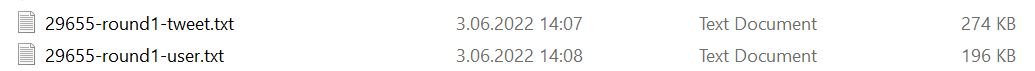

In [68]:
display.Image("https://i.imgur.com/lcwRsOW.png")

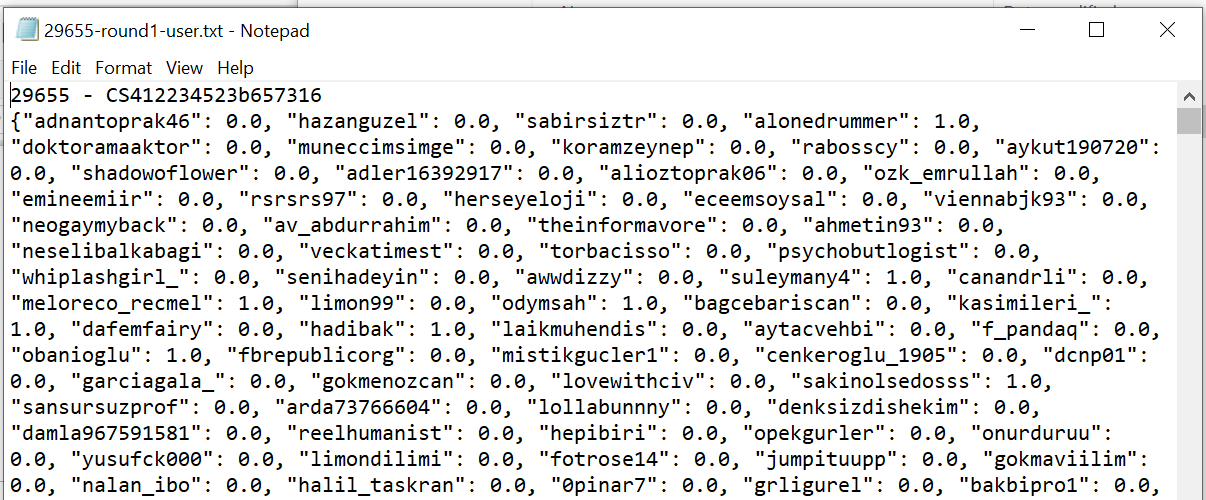

In [69]:
display.Image("https://i.imgur.com/qfxqgMF.png")

You can check whether you can read your predictions correctly or not:

In [71]:
with open('{}/{}-round{}-tweet3.txt'.format(DATA_PATH, STUDENT_ID, ROUND), 'r') as fl:
    file = fl.read()

student_info = file.split("\n")[0]
predictions = eval(file.split("\n")[1])

FileNotFoundError: ignored